In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:

env = gym.make("Taxi-v3")
env.reset()

episodes = 5000
gamma = 0.9  

alpha_td = 0.9
epsilon_td = 0.1

alpha_mc = 0.9
epsilon_mc = 0.1


In [3]:
num_rows = env.observation_space.n
num_columns = env.action_space.n
qtable_td = np.zeros((num_rows, num_columns))
qtable_mc = np.zeros((num_rows, num_columns))

In [4]:
rewards_td = np.zeros(episodes)
rewards_mc = np.zeros(episodes)

In [5]:
def monte_carlo_episode():
    episode = []
    state = env.reset()[0]
    done = False
    while not done:
        if np.random.uniform(0, 1) < epsilon_mc:
            action = env.action_space.sample()
        else:
            action = np.argmax(qtable_mc[state])
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward))
        state = new_state

    total_reward = 0
    for state, action, reward in reversed(episode):
        total_reward = reward + gamma * total_reward
        qtable_mc[state, action] += alpha_mc * (total_reward - qtable_mc[state, action])
    return sum([x[2] for x in episode])

In [6]:
def td_episode():
    total_reward = 0
    state = env.reset()[0]
    done = False
    while not done:
        if np.random.uniform(0, 1) < epsilon_td:
            action = env.action_space.sample()
        else:
            action = np.argmax(qtable_td[state])
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        qtable_td[state, action] += alpha_td * (reward + gamma * np.max(qtable_td[new_state]) - qtable_td[state, action])
        state = new_state
    return total_reward

In [7]:
for epi in range(episodes):
    rewards_mc[epi] = monte_carlo_episode()
    rewards_td[epi] = td_episode()

In [8]:
cumulative_rewards_mc = np.cumsum(rewards_mc)
cumulative_rewards_td = np.cumsum(rewards_td)

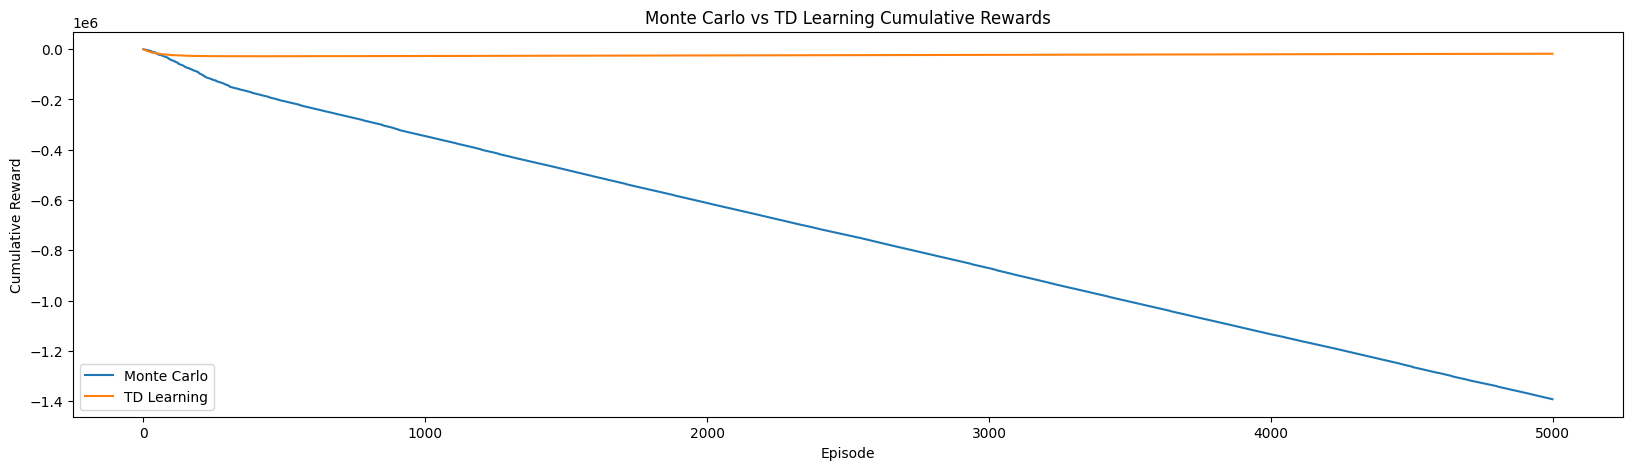

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(range(episodes), cumulative_rewards_mc, label='Monte Carlo')
plt.plot(range(episodes), cumulative_rewards_td, label='TD Learning')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Monte Carlo vs TD Learning Cumulative Rewards')
plt.legend()
plt.show()

In [10]:
def run_td_experiment(alpha, epsilon):
    qtable_td_exp = np.zeros((num_rows, num_columns))
    rewards_td_exp = np.zeros(episodes)
    for epi in range(episodes):
        total_reward = 0
        state = env.reset()[0]
        done = False
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable_td_exp[state])
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            qtable_td_exp[state, action] += alpha * (reward + gamma * np.max(qtable_td_exp[new_state]) - qtable_td_exp[state, action])
            state = new_state
        rewards_td_exp[epi] = total_reward
    return np.cumsum(rewards_td_exp)

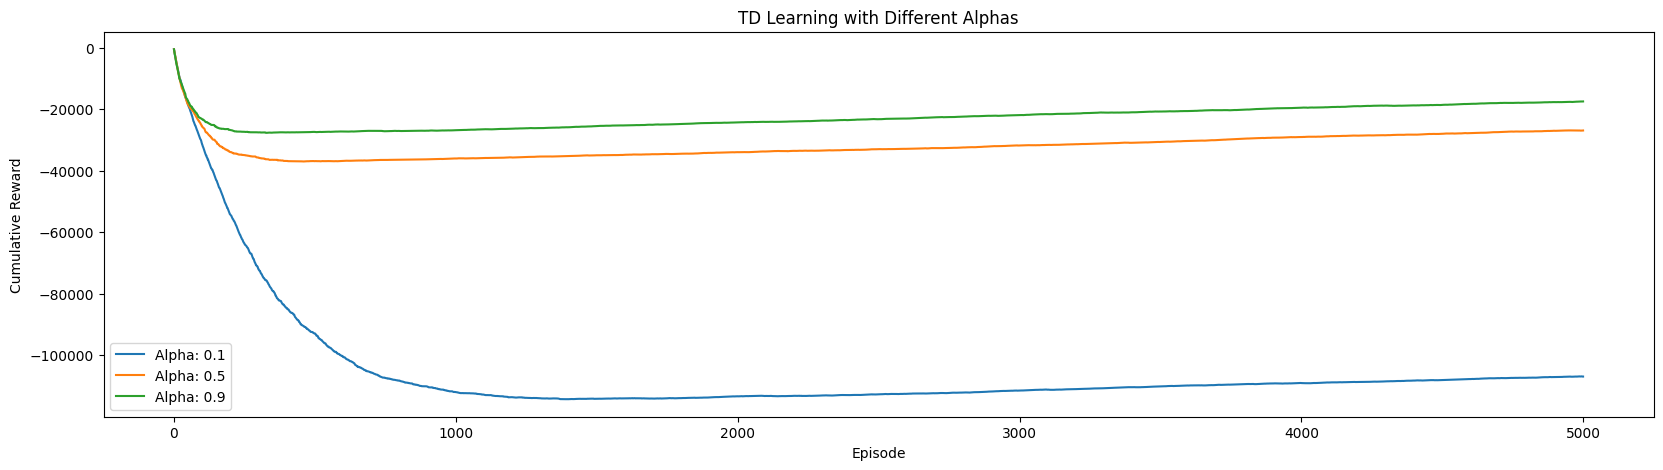

In [11]:
plt.figure(figsize=(20, 5))
for alpha in [0.1, 0.5, 0.9]:
    cumulative_rewards = run_td_experiment(alpha, epsilon_td)
    plt.plot(range(episodes), cumulative_rewards, label=f'Alpha: {alpha}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('TD Learning with Different Alphas')
plt.legend()
plt.show()

In [12]:
def run_mc_experiment(alpha, epsilon):
    qtable_mc_exp = np.zeros((num_rows, num_columns))
    rewards_mc_exp = np.zeros(episodes)
    for epi in range(episodes):
        episode = []
        state = env.reset()[0]
        done = False
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable_mc_exp[state])
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = new_state

        total_reward = 0
        for state, action, reward in reversed(episode):
            total_reward = reward + gamma * total_reward
            qtable_mc_exp[state, action] += alpha * (total_reward - qtable_mc_exp[state, action])
        rewards_mc_exp[epi] = sum([x[2] for x in episode])
    return np.cumsum(rewards_mc_exp)

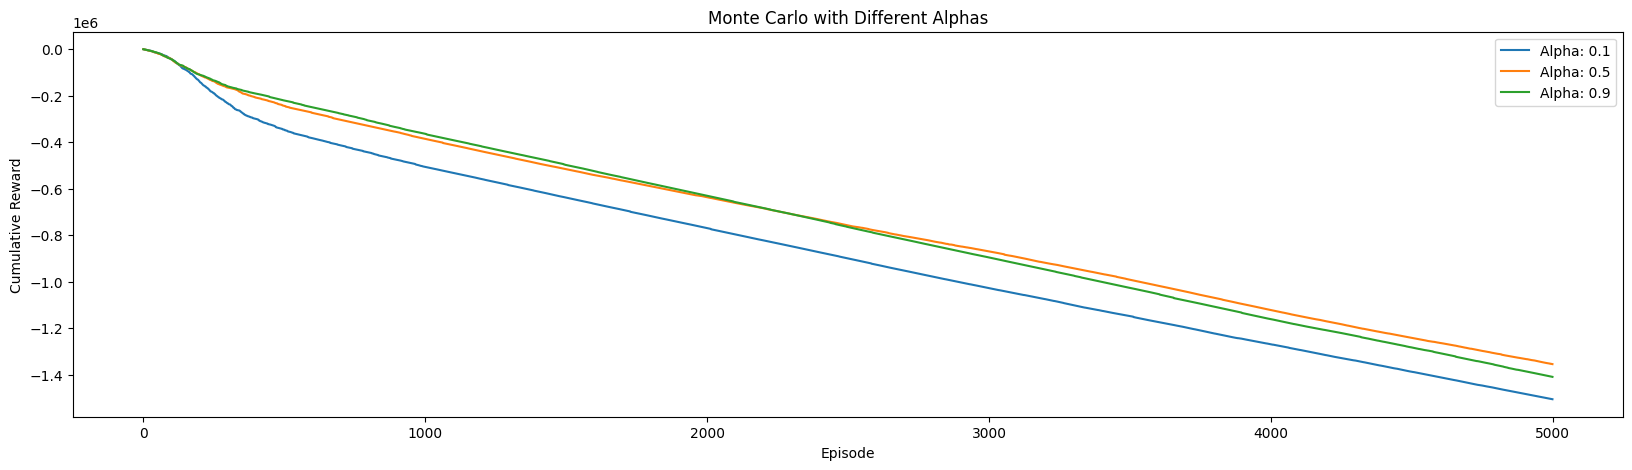

In [13]:
plt.figure(figsize=(20, 5))
for alpha in [0.1, 0.5, 0.9]:
    cumulative_rewards = run_mc_experiment(alpha, epsilon_mc)
    plt.plot(range(episodes), cumulative_rewards, label=f'Alpha: {alpha}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Monte Carlo with Different Alphas')
plt.legend()
plt.show()

In [14]:
def evaluate_performance(qtable, num_trials=1000):
    sum_rewards = 0
    counter_successful = 0
    counter_unsuccessful = 0

    for _ in range(num_trials):
        state = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(qtable[state])
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = new_state

        if total_reward != -200:
            sum_rewards += total_reward
            counter_successful += 1
        else:
            counter_unsuccessful += 1

    average_reward = sum_rewards / counter_successful if counter_successful > 0 else 0
    return average_reward, counter_successful, counter_unsuccessful


In [15]:
# Evaluate Monte Carlo performance
avg_reward_mc, successful_runs_mc, unsuccessful_runs_mc = evaluate_performance(qtable_mc)
print("Monte Carlo Performance:")
print(f"Average reward in successful runs: {avg_reward_mc}")
print(f"No. of successful runs: {successful_runs_mc}")
print(f"No. of unsuccessful runs: {unsuccessful_runs_mc}")

# Evaluate TD Learning performance
avg_reward_td, successful_runs_td, unsuccessful_runs_td = evaluate_performance(qtable_td)
print("TD Learning Performance:")
print(f"Average reward in successful runs: {avg_reward_td}")
print(f"No. of successful runs: {successful_runs_td}")
print(f"No. of unsuccessful runs: {unsuccessful_runs_td}")

Monte Carlo Performance:
Average reward in successful runs: -119.70967741935483
No. of successful runs: 31
No. of unsuccessful runs: 969
TD Learning Performance:
Average reward in successful runs: 7.844
No. of successful runs: 1000
No. of unsuccessful runs: 0
